<a href="https://colab.research.google.com/github/CopypastCore/IAD/blob/main/determination_of_profit%26loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Набор данных cхемы пирамиды – определение прибыли или убытка. Схемы
пирамид, запущенные в разных странах, часто соблазняют простых людей
делать деньги в краткосрочной перспективе. Построить регрессионную модель
прогностической оценки схемы пирамиды для целевого признака «profit»
(выгода от схемы) от остальных входных признаков.  
a.   Пункт 5 – простая рекуррентная сеть
b.   Пункт 3.h – Нормализация

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers, models
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [79]:
dataset = pd.read_csv('/content/drive/MyDrive/V8.csv')
df = dataset.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, errors='ignore')
print(df.head())

   cost_price  profit_markup  depth_of_tree  sales_commission  profit
0      3500.0              2             21              1000  -16500
1      3500.0              2             26              1000  -21500
2         NaN              2             23              1000  -18500
3         NaN              3             12              1000   -4000
4      3500.0              2             12              1000   -7500


In [80]:
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nОсновные статистики:")
print(df.describe().T)
print("\nПроверка на пропущенные значения:")
print(df.isnull().sum())


Размер датасета: (500, 5)

Первые 5 строк:
   cost_price  profit_markup  depth_of_tree  sales_commission  profit
0      3500.0              2             21              1000  -16500
1      3500.0              2             26              1000  -21500
2         NaN              2             23              1000  -18500
3         NaN              3             12              1000   -4000
4      3500.0              2             12              1000   -7500

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cost_price        244 non-null    float64
 1   profit_markup     500 non-null    int64  
 2   depth_of_tree     500 non-null    int64  
 3   sales_commission  500 non-null    int64  
 4   profit            500 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 19.7 KB
None

Основные статистики:
    

In [81]:
# Проверка дубликатов
duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов: {duplicates}")

Количество полных дубликатов: 289


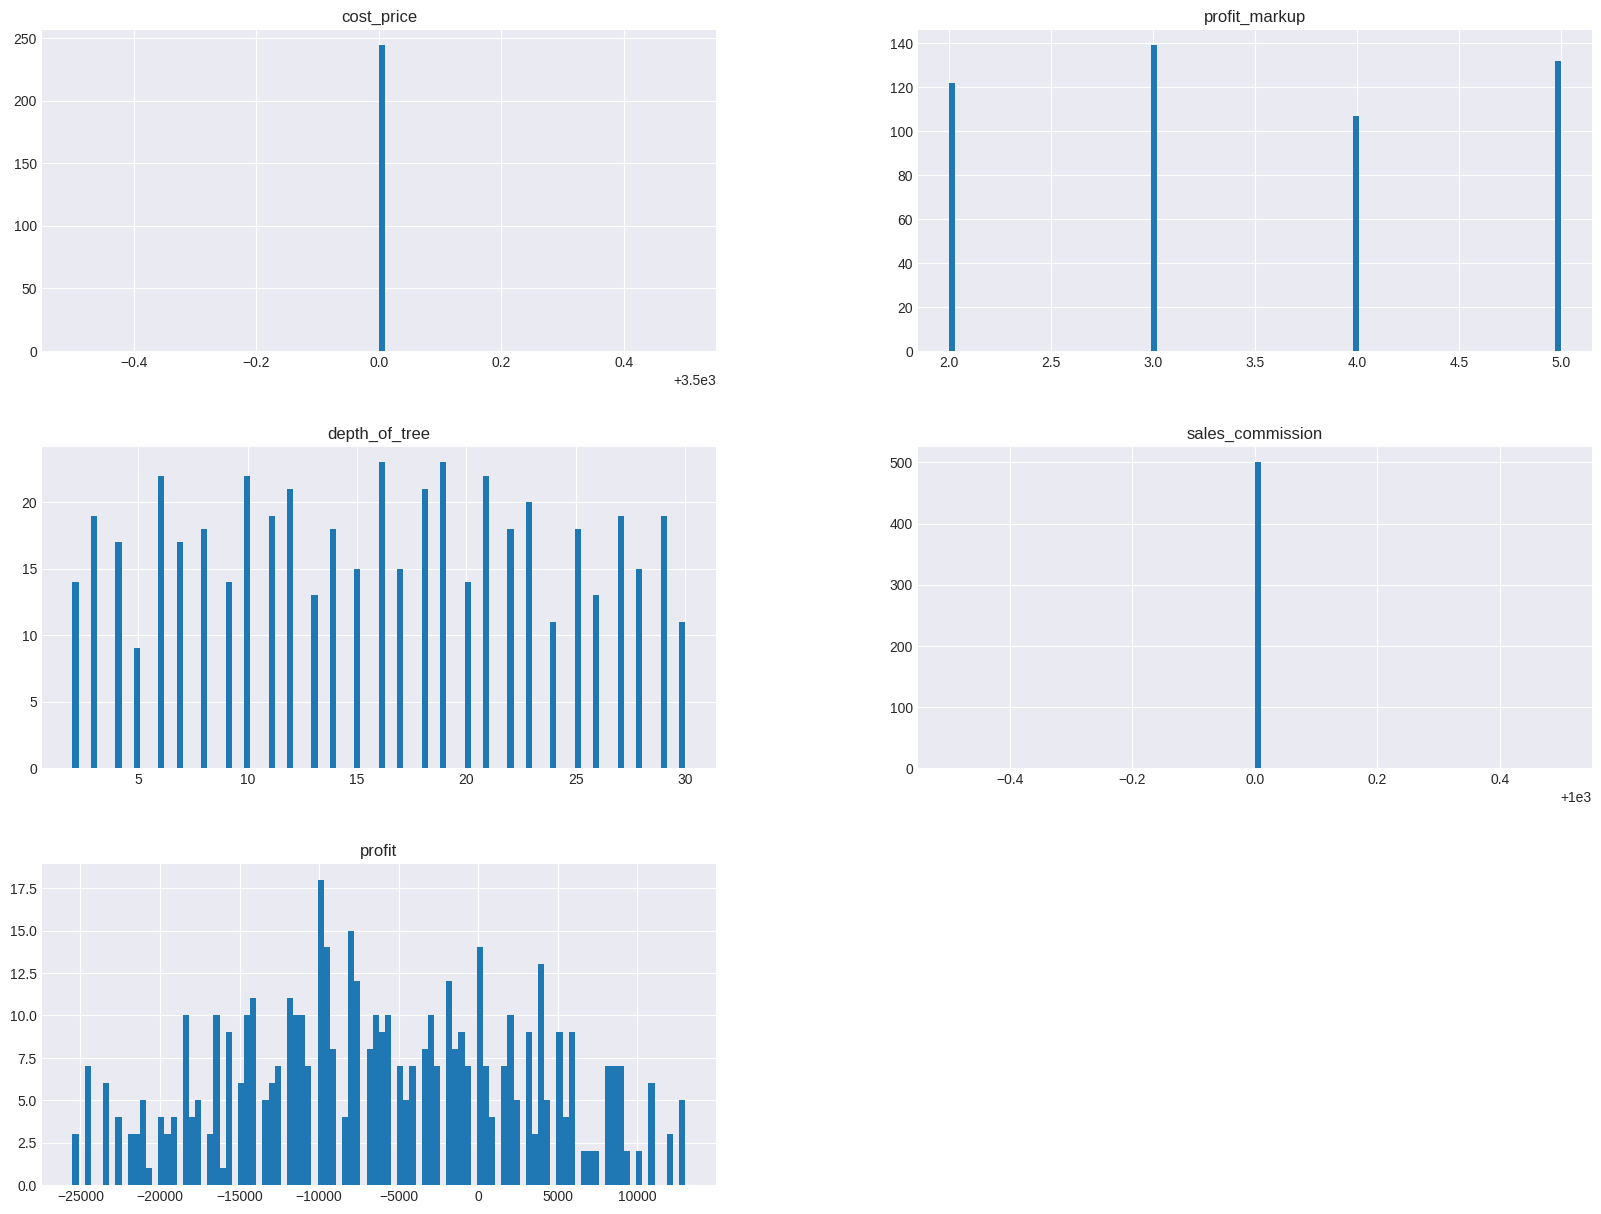


Матрица диаграмм рассеяния:


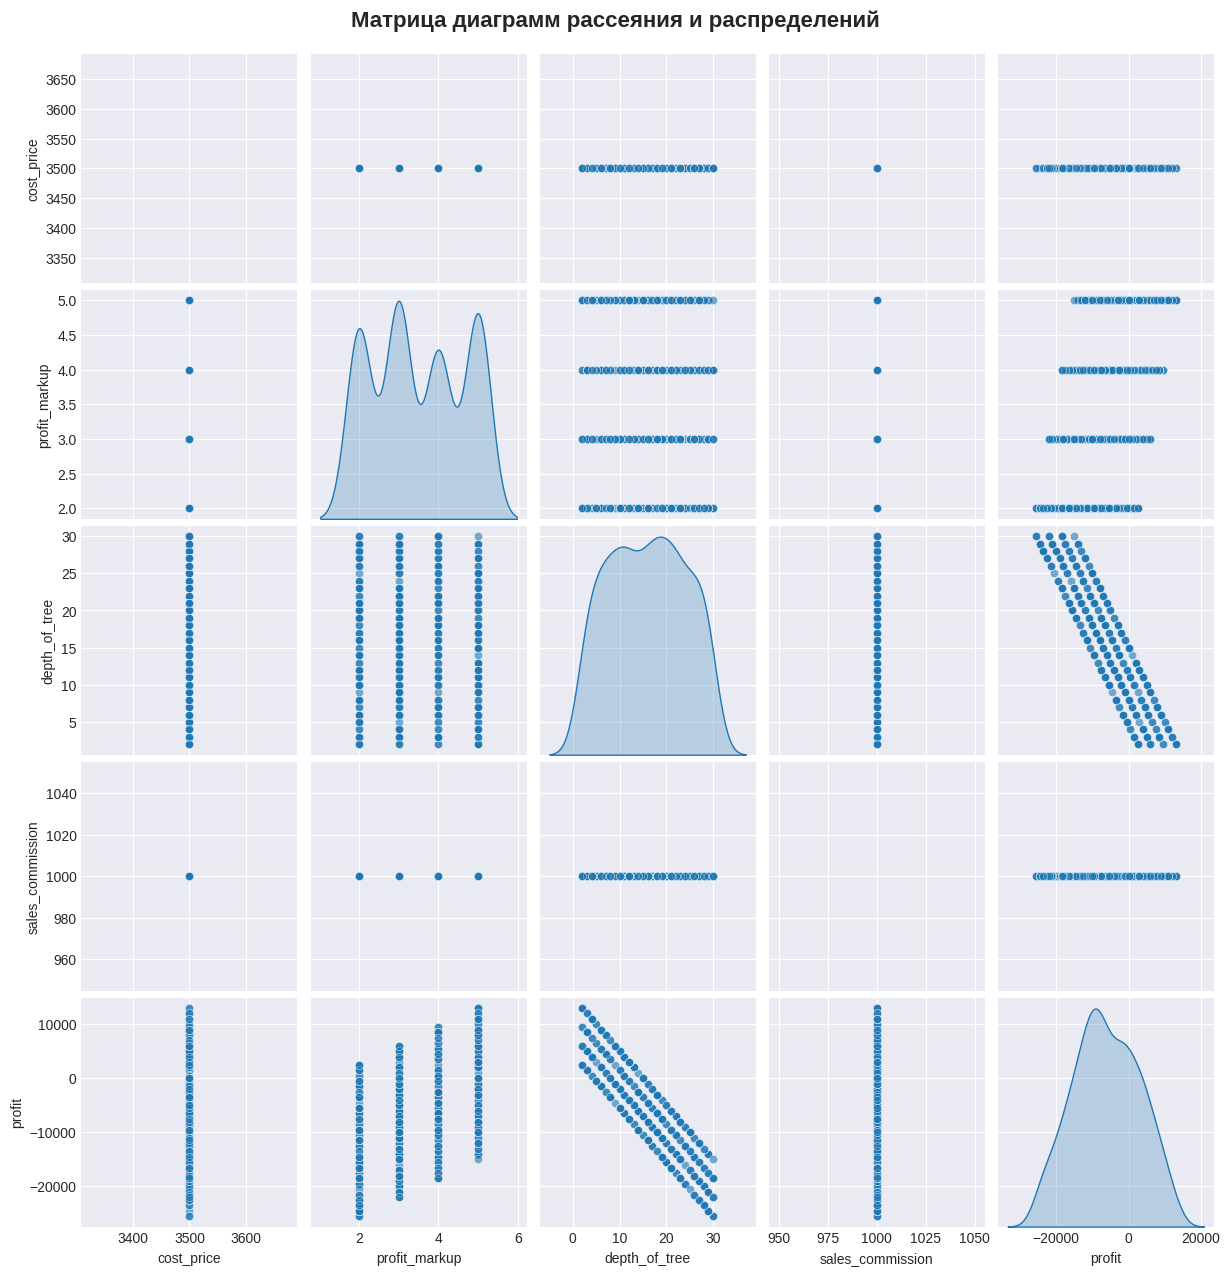

In [82]:
%matplotlib inline
df.hist(bins=100, figsize=(20,15))
plt.show()

# Матрица диаграмм рассеяния
print("\nМатрица диаграмм рассеяния:")
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Матрица диаграмм рассеяния и распределений', y=1.02, fontsize=16, fontweight='bold')
plt.show()

In [83]:
print("\n3.c. Очистка данных")
print(f"Количество строк до очистки: {len(df)}")

# Заполнение пропущенных значений в cost_price медианным значением
df['cost_price'] = df['cost_price'].fillna(df['cost_price'].median())
print("Пропущенные значения после обработки:")
print(df.isnull().sum())
df


3.c. Очистка данных
Количество строк до очистки: 500
Пропущенные значения после обработки:
cost_price          0
profit_markup       0
depth_of_tree       0
sales_commission    0
profit              0
dtype: int64


,cost_price,profit_markup,depth_of_tree,sales_commission,profit
0,3500.0,2,21,1000,-16500
1,3500.0,2,26,1000,-21500
2,3500.0,2,23,1000,-18500
3,3500.0,3,12,1000,-4000
4,3500.0,2,12,1000,-7500
...,...,...,...,...,...
495,3500.0,5,12,1000,3000
496,3500.0,3,8,1000,0
497,3500.0,2,10,1000,-5500
498,3500.0,4,21,1000,-9500


Корреляционная матрица:
                  cost_price  profit_markup  depth_of_tree  sales_commission  \
cost_price               NaN            NaN            NaN               NaN   
profit_markup            NaN       1.000000      -0.021562               NaN   
depth_of_tree            NaN      -0.021562       1.000000               NaN   
sales_commission         NaN            NaN            NaN               NaN   
profit                   NaN       0.453341      -0.900905               NaN   

                    profit  
cost_price             NaN  
profit_markup     0.453341  
depth_of_tree    -0.900905  
sales_commission       NaN  
profit            1.000000  


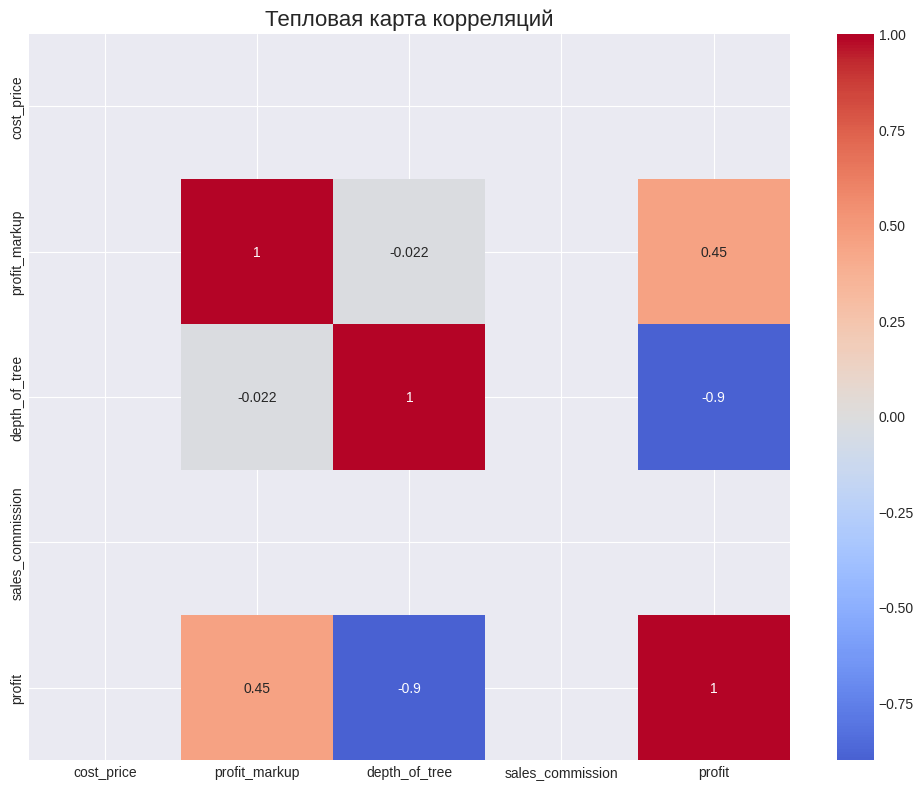

In [85]:
corr_matrix = df.corr()
print("Корреляционная матрица:")
print(corr_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Тепловая карта корреляций', fontsize=16)
plt.tight_layout()
plt.show()

In [86]:
# Создание новых признаков
df['total_cost'] = df['cost_price'] + df['sales_commission']
df['profit_per_depth'] = df['profit'] / (df['depth_of_tree'] + 1)
df['markup_depth_interaction'] = df['profit_markup'] * df['depth_of_tree']
df['cost_markup_ratio'] = df['cost_price'] / (df['profit_markup'] + 1)

print("Добавлены новые признаки: total_cost, profit_per_depth, markup_depth_interaction, cost_markup_ratio")
print(df[['total_cost', 'profit_per_depth', 'markup_depth_interaction', 'cost_markup_ratio']].head())

Добавлены новые признаки: total_cost, profit_per_depth, markup_depth_interaction, cost_markup_ratio
   total_cost  profit_per_depth  markup_depth_interaction  cost_markup_ratio
0      4500.0       -750.000000                        42        1166.666667
1      4500.0       -796.296296                        52        1166.666667
2      4500.0       -770.833333                        46        1166.666667
3      4500.0       -307.692308                        36         875.000000
4      4500.0       -576.923077                        24        1166.666667


In [87]:
# Выбираем признаки с высокой корреляцией с целевой переменной
target_corr = corr_matrix['profit'].abs().sort_values(ascending=False)
print("Корреляция признаков с целевой переменной profit:")
print(target_corr)

Корреляция признаков с целевой переменной profit:
profit              1.000000
depth_of_tree       0.900905
profit_markup       0.453341
cost_price               NaN
sales_commission         NaN
Name: profit, dtype: float64


In [89]:
# Выбираем признаки с корреляцией > 0.1
significant_features = target_corr[target_corr > 0.1].index.tolist()
significant_features.remove('profit')
print(f"\nСущественные признаки: {significant_features}")


Существенные признаки: ['depth_of_tree', 'profit_markup']


In [90]:
# Создаем набор данных из существенных признаков
df_significant = df[significant_features + ['profit']].copy()
print(f"\nРазмерность набора с существенными признаками: {df_significant.shape}")


Размерность набора с существенными признаками: (500, 3)


In [95]:
# Функция для нормализации данных


def normalize_data(df_to_normalize, target_col='profit'):

    df_copy = df_to_normalize.copy()

    # Отделяем целевую переменную
    if target_col in df_copy.columns:
        y = df_copy[target_col]
        X = df_copy.drop(columns=[target_col])
    else:
        X = df_copy
        y = None

    # Нормализуем признаки
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

    # Восстанавливаем целевую переменную
    if y is not None:
        X_normalized_df[target_col] = y.values

    return X_normalized_df, scaler

# Нормализация исходного набора
df_original_normalized, scaler_original = normalize_data(df)

# Нормализация набора с существенными признаками
df_significant_normalized, scaler_significant = normalize_data(df_significant)

print("Исходный набор после нормализации:")
print(df_original_normalized.head())

print("\nНабор с существенными признаками после нормализации:")
print(df_significant_normalized.head())

Исходный набор после нормализации (первые 5 строк):
   cost_price  profit_markup  depth_of_tree  sales_commission  total_cost  \
0         0.0       0.000000       0.678571               0.0         0.0   
1         0.0       0.000000       0.857143               0.0         0.0   
2         0.0       0.000000       0.750000               0.0         0.0   
3         0.0       0.333333       0.357143               0.0         0.0   
4         0.0       0.000000       0.357143               0.0         0.0   

   profit_per_depth  markup_depth_interaction  cost_markup_ratio  profit  
0          0.014077                  0.260274                1.0  -16500  
1          0.005098                  0.328767                1.0  -21500  
2          0.010036                  0.287671                1.0  -18500  
3          0.099864                  0.219178                0.5   -4000  
4          0.047646                  0.136986                1.0   -7500  

Набор с существенными признаками п

In [96]:
datasets = {
    'original': df,  # Используем очищенный набор без столбца 'Unnamed: 0'
    'original_normalized': df_original_normalized,
    'significant': df_significant,
    'significant_normalized': df_significant_normalized
}

# Функция для разделения данных
def prepare_datasets(datasets_dict, test_size=0.2, val_size=0.2, random_state=42):
    prepared_data = {}

    for name, dataset in datasets_dict.items():
        # Определяем признаки и целевую переменную
        X = dataset.drop(columns=['profit'])
        y = dataset['profit']

        # Разделяем на обучающую+валидационную и тестовую
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Разделяем обучающую+валидационную на обучающую и валидационную
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=random_state
        )

        prepared_data[name] = {
            'X_train': X_train, 'y_train': y_train,
            'X_val': X_val, 'y_val': y_val,
            'X_test': X_test, 'y_test': y_test
        }

        print(f"\n{name}:")
        print(f"  Обучающая выборка: {X_train.shape[0]} samples")
        print(f"  Валидационная выборка: {X_val.shape[0]} samples")
        print(f"  Тестовая выборка: {X_test.shape[0]} samples")
        print(f"  Количество признаков: {X_train.shape[1]}")

    return prepared_data

# Подготавливаем все наборы данных
prepared_data = prepare_datasets(datasets)


original:
  Обучающая выборка: 300 samples
  Валидационная выборка: 100 samples
  Тестовая выборка: 100 samples
  Количество признаков: 8

original_normalized:
  Обучающая выборка: 300 samples
  Валидационная выборка: 100 samples
  Тестовая выборка: 100 samples
  Количество признаков: 8

significant:
  Обучающая выборка: 300 samples
  Валидационная выборка: 100 samples
  Тестовая выборка: 100 samples
  Количество признаков: 2

significant_normalized:
  Обучающая выборка: 300 samples
  Валидационная выборка: 100 samples
  Тестовая выборка: 100 samples
  Количество признаков: 2
